In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import geopandas as gpd

import extracting_points_from_polygons as pp

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import pystac_client 
import planetary_computer as pc

import iceplant_detection_functionsCopy1 as ipf

In [2]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')


# def aoi_to_samples(root,aoi,year):
#     # root for all polygons collected on naip scenes
#     fp = os.path.join(root, 
#                       aoi+'_polygons', 
#                       aoi+'_polygons_'+str(year), 
#                       aoi+'_polygons_'+str(year)+'.shp')
#     polys = gpd.read_file(fp)
#     itemid = polys['naip_id'][0]
#     points = pp.naip_sample_no_warnings(polys,itemid)
#     return points

In [3]:
root = '/home/jovyan/msai4earth-esa/iceplant_detection'
aois = gpd.read_file(os.path.join(root,'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

In [4]:
aoi = 'campus_lagoon'
year = 2018 
fp = pp.path_to_polygons(aoi,year)
polys = gpd.read_file(fp)
#polys_raw

## Sampling 20% of pixels

In [5]:
sample1 = pp.naip_sample_proportion_no_warnings(polys, polys.naip_id[0], 0.2)

In [6]:
ipf.iceplant_proportions(sample1.iceplant)

no-iceplant:iceplant ratio     62.2 :1
          counts  percentage
iceplant                    
0         100065       98.42
1           1609        1.58



### Random forest

Text(0.5, 1.0, 'point samples by polygon id --- 0.2 samples')

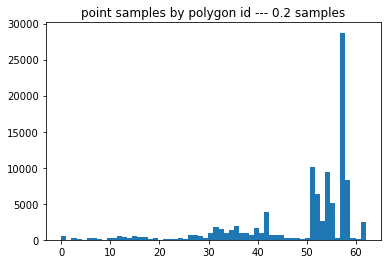

In [7]:
plt.hist(sample1.polygon_id,bins=60)
plt.title('point samples by polygon id --- 0.2 samples')

In [8]:
counts = np.unique(sample1.polygon_id.to_numpy(), return_counts=True)
counts = pd.DataFrame({'poly_id':counts[0], 'count':counts[1]}).sort_values(by=['count'], ascending=False)
counts.head(10)

,poly_id,count
54,57,28729
48,51,10066
51,54,9412
55,58,8334
49,52,6398
52,55,5071
39,42,3827
50,53,2667
59,62,2109
33,36,1852


In [9]:
counts.tail(5)

,poly_id,count
4,4,96
0,0,59
23,25,51
5,5,39
2,2,32


In [10]:
sample1.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample1 = sample1[['r','g','b','nir','iceplant']]
#sample1

In [11]:
# Labels & Features
y = np.array(sample1['iceplant'])
X = np.array(sample1.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [12]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 29934     false positives: 70
false negatives: 99     true positives: 400

sensitivity (TP/P): 80.16 %
specificity (TN/N): 99.77 %
G-mean:  0.89

precision (TP/(TP+FP)): 85.11 %

MCC:  0.8231617401894974

F1-measure:  0.82559
F0.5-measure (min false positives):  0.84069
F2-measure (min false negatives)  :  0.81103

accuracy: 99.45 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


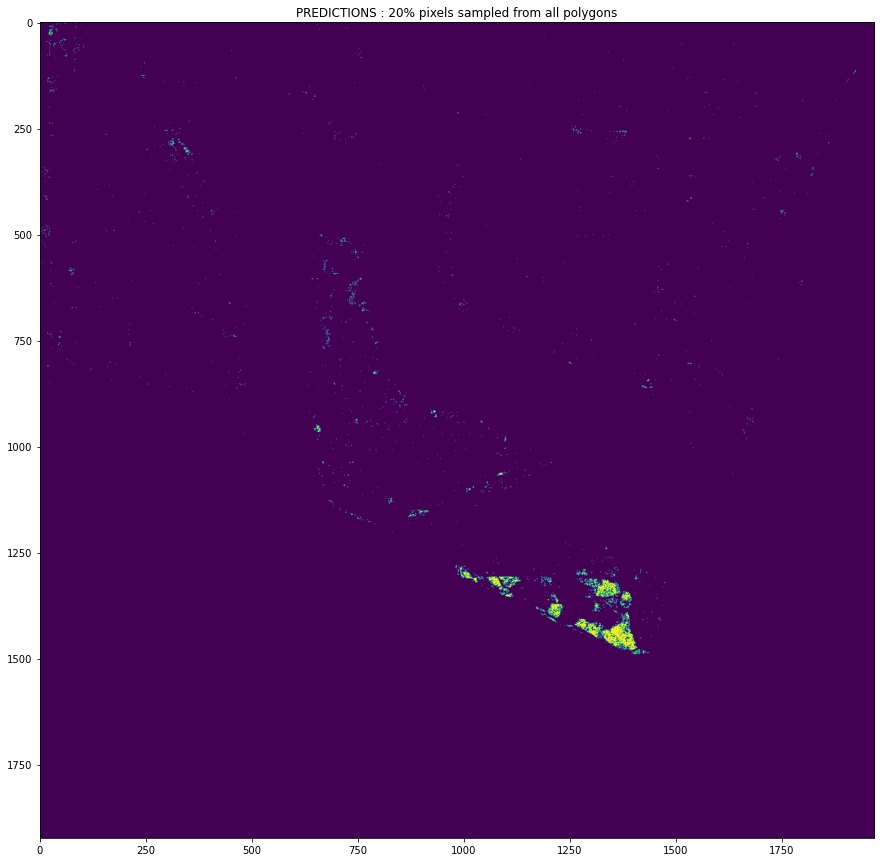

In [13]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 20% pixels sampled from all polygons")
ax.imshow(reconstructed)
plt.show()

## Sampling 0.8 iceplant, 0.2 non-iceplant

In [14]:
polys_iceplant = polys.loc[polys.iceplant==1]
polys_iceplant.reset_index(inplace=True, drop=True)

polys_noniceplant = polys.loc[polys.iceplant==0]
polys_noniceplant.reset_index(inplace=True, drop=True)

In [15]:
pts_iceplant = pp.naip_sample_proportion_no_warnings(polys_iceplant, polys.naip_id[0], 0.8)
pts_noniceplant = pp.naip_sample_proportion_no_warnings(polys_noniceplant, polys.naip_id[0], 0.2)

In [16]:
sample2 = pd.concat([pts_iceplant, pts_noniceplant])
ipf.iceplant_proportions(sample2.iceplant)

no-iceplant:iceplant ratio     15.5 :1
          counts  percentage
iceplant                    
0         100065       93.95
1           6449        6.05



In [17]:
sample2.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample2 = sample2[['r','g','b','nir','iceplant']]

In [18]:
# Labels & Features
y = np.array(sample2['iceplant'])
X = np.array(sample2.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [19]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y, predictions)


true negatives: 29889     false positives: 166
false negatives: 141     true positives: 1759

sensitivity (TP/P): 92.58 %
specificity (TN/N): 99.45 %
G-mean:  0.96

precision (TP/(TP+FP)): 91.38 %

MCC:  0.914651468940732

F1-measure:  0.91974
F0.5-measure (min false positives):  0.91615
F2-measure (min false negatives)  :  0.92336

accuracy: 99.04 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


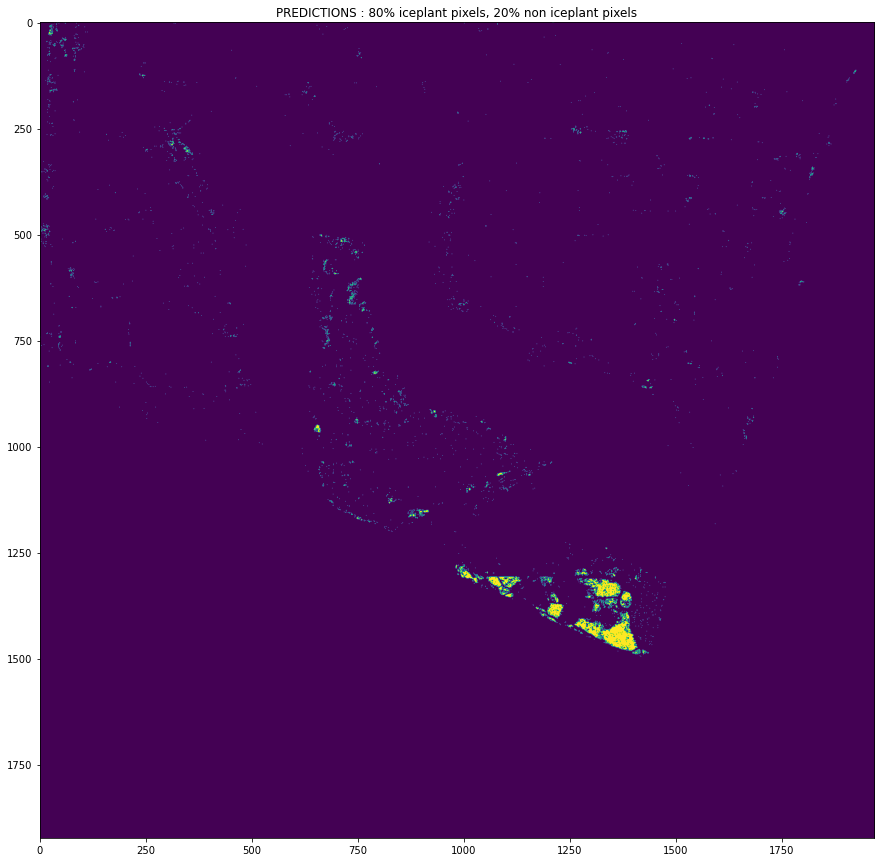

In [20]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 80% iceplant pixels, 20% non iceplant pixels")
ax.imshow(reconstructed)
plt.show()

## Custom sampling
Sampling 250 pts from each non-iceplant polygon and 80% of all pixels in the iceplant polygons

In [21]:
pts_non250 = pp.naip_sample_n_no_warnings(polys_noniceplant, polys.naip_id[0], 250)

In [22]:
sample3 = pd.concat([pts_iceplant, pts_non250])
ipf.iceplant_proportions(sample3.iceplant)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          12750       66.41
1           6449       33.59



In [23]:
sample3.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample3 = sample3[['r','g','b','nir','iceplant']]

In [24]:
# Labels & Features
y = np.array(sample3['iceplant'])
X = np.array(sample3.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [25]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 3774     false positives: 66
false negatives: 44     true positives: 1876

sensitivity (TP/P): 97.71 %
specificity (TN/N): 98.28 %
G-mean:  0.98

precision (TP/(TP+FP)): 96.6 %

MCC:  0.9571891304136577

F1-measure:  0.97152
F0.5-measure (min false positives):  0.96821
F2-measure (min false negatives)  :  0.97485

accuracy: 98.09 %



In [ ]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 250 pixels from each non-iceplant polygon, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()

/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


In [ ]:
df = pd.concat([pts_ice,pts_nonice])
df.drop(['geometry','x','y','naip_id','polygon_id','month','day','year'], axis=1, inplace=True)
df['ndvi'] = (df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
df = df[['r','g','b','nir','ndvi','iceplant']]
df